In [17]:
# %load advancednn.py
# %load blncq.py
import pygame
import torch

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import random
import matplotlib.pyplot as plt
import os
from collections import deque

import IPython.display

print("OK")

pygame.init()

# Pygame screen size:
sx = 900
sy = 500

# Table hgitht, left brim, right brim...
tableH = sy-20
tableL = int(sx*0.1)
tableR = int(sx*0.9)

# Stick picture size:
stickL = 400
stickW = 50

cticker = pygame.time.Clock()
testsc = pygame.display.set_mode((sx, sy))

im_bg = pygame.image.load("assets/bg.png").convert_alpha()
im_st = pygame.image.load("assets/pp.png").convert_alpha()

im_bg = pygame.transform.scale(im_bg, (sx,sy))
im_st = pygame.transform.scale(im_st, (stickW, stickL))

# 
def get_bottom(img, th, bwidth = stickW):
    x = -img.get_rect()[2]
    y = -img.get_rect()[3]
    if np.sin(th)<0:
        x=0
    if np.cos(th)<0:
        y=0
    bx = np.sign(np.cos(th)) * np.abs(np.sin(th)) * bwidth/2
    by = np.sign(np.sin(th)) * np.abs(np.cos(th)) * bwidth/2
    return (x+by, y+bx)

#for i in range(1300):
#     testsc.blit(im_bg, (0,0))
#     tst = pygame.transform.rotate(im_st, i)
#     x,y = get_bottom(tst, i*np.pi/180)
#     testsc.blit(tst, (500+x,300+y))
#     # testsc.blit(im_bd, (300,500))
#     # print(tst.get_rect(),(x,y))
#     pygame.display.update()
#     cticker.tick(30)
    


class gameState():
    def __init__(self, th,w, x, v, g=1, zhuanguan=10):
        self.th = th
        self.w = w
        self.x = x
        self.v = v
        self.g = g
        self.guanliang = zhuanguan

    def forward(self, dv, disp = 0):
        self.v += dv
        self.x += self.v
        self.w +=  ( dv * np.cos(self.th*np.pi/180) + self.g * np.sin(self.th*np.pi/180))/self.guanliang
        self.th += self.w
        
        if disp == 1:
            one_frame = self.drawgame()
        else:
            one_frame = []

        ##
        stateLabel = 1
        if self.x < tableL or self.x > tableR or self.th < -90 or self.th > 90:
            stateLabel = 0
        ##
        return np.stack((self.th, self.w, self.x, self.v), axis=0), stateLabel, one_frame
    
    def drawgame(self):
        testsc.blit(im_bg, (0, 0))
        tst = pygame.transform.rotate(im_st, self.th)
        x,y = get_bottom(tst, self.th*np.pi/180)
        testsc.blit(tst, (self.x + x, tableH + y))
        pygame.display.update()
        cticker.tick(30)
        return pygame.surfarray.array3d(pygame.display.get_surface())

    def printgame(self):
        print("Theta:%s, w: %s, position_x: %s, v: %s" % (self.th, self.w, self.x, self.v))
    ##

    def plotgame(self, fig, img):
        IPython.display.clear_output(wait=True)
        img.set_data(image_data)
        IPython.display.display(fig)
        cticker.tick(30)

    def getState(self):
        return np.stack((self.th, self.w, self.x, self.v) , axis=0)

    def gameinit(self, dis = 5):
        self.th = (np.random.rand()-0.5)*2*dis
        self.w = 0.0
        self.x = np.random.choice(range(tableL+200, tableR-200))
        self.v = np.random.rand()-0.5
        

game = gameState(1.0,0.0,400.0,0.0)

# for i in range(200):
#     x,s = game.forward(np.random.rand()-0.5,1)
#     # game.printgame()
#     if s==0:
#         game.printgame()
#         break

    


# In[ ]:




OK


In [18]:
class ActionNN(nn.Module):
    def __init__(self, ni, no, nh=20, scale = 20):
        super(ActionNN, self).__init__()
        self.inputN = ni
        self.hiddenN = nh
        self.outN = no
        self.scale = 20
        self.fc1 = nn.Linear(ni, nh)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(nh, no)
        self.ss = nn.Softsign()
    ##
    def forward(self, input):
        out = self.fc1(input)
        out = self.relu(out)
        out = self.fc2(out)
        out= self.scale * self.ss(out)
        
        return out
    ##
##

class QValue(nn.Module):
    def __init__(self, ni, nh=20):
        super(QValue, self).__init__()
        self.inputN = ni
        self.fc1 = nn.Linear(ni, nh)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(nh,1)
    ##
    def forward(self, stateAction):
        sa = stateAction
        out = self.fc1(sa)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    ##
##
def catsa(s,a):
    sss = Variable(torch.Tensor(s), requires_grad = False)
    result =  torch.cat((sss,a))
    return result

In [19]:
try:
    netA2 = torch.load("./models/newA.mdl")
    netQ2 = torch.load("./models/newQ.mdl")
    netA = netA2
    netQ = netQ2
except:
    print("Loading 粗问题了")
    netA = ActionNN(4,1)
    netQ = QValue(5)
    
critS = nn.MSELoss()
optimizerA = torch.optim.Adam(netA.parameters(), lr=1e-3)
optimizerQ = torch.optim.Adam(netQ.parameters(), lr = 2e-4)

records = deque()
recoMax = 50000

###    return torch.cat((torch.Tensor(np.array(s)), torch.Tensor([a])))
game.gameinit()

def repeatGame(g, ann, epochN=100, disp_game=0):
    for epoch in range(epochN):
        s1 = g.getState()
        a = ann(Variable(torch.FloatTensor(s1)))
        
        s2, label, oneframe = g.forward(a.data[0], disp=disp_game)
        if label == 0:
            r = -100
            g.gameinit()
        else:
            r = 1
        epochRecord = (s1, a, r, s2, label)
        records.append(epochRecord)
        if len(records) > recoMax:
            records.popleft()
##

def getLoss(sigma = 0.999999):
    minibatch = random.sample(records, batchSize)
    qt  = [netQ( catsa( minibatch[i][0], minibatch[i][1])) for i in range(batchSize)]
    stt = [netA( Variable(torch.FloatTensor(np.array(minibatch[i][3])))) for i in range(batchSize)]
    qtt = [minibatch[i][4] * netQ( catsa(minibatch[i][3], stt[i]) ) for i in range(batchSize)]
    betterQ = []
    for i in range(batchSize):
        qq = sigma * qtt[i] + minibatch[i][2]
        ##qq.requires_grad = False
        qq = qq.detach()
        betterQ.append(qq)
    ##
    lossQ = sum( [critS(qt[i], betterQ[i]) for i in range(batchSize)] )
    lossA = -sum(qtt)

    return lossQ, lossA
##

repeatGame(game, netA, 100)

Loading 粗问题了


In [20]:


epochN = 600000
batchSize = 40


for epoch in range(epochN):
    
    repeatGame(game, netA, 10)
    
    
    lossQ, lossA = getLoss()
    
    optimizerA.zero_grad()
    lossA.backward(retain_graph = True)
    optimizerA.step()
    
    optimizerQ.zero_grad()
    lossQ.backward(retain_graph=True)
    optimizerQ.step()

    if epoch%100 == 0:
        print(epoch)
        print("Loss_of_Action: %f; loss_of_Q: %f" %(lossA.data[0], lossQ.data[0]))
        torch.save(netA, "models/newA.mdl")
        torch.save(netQ, "models/newQ.mdl")


## Test Section...

###

# fig = plt.figure()
# axe = fig.gca()
# pl = axe.imshow(np.random.random([sy, sx]))

# for i in range(100):
#     IPython.display.clear_output(True)
#     s = game.getState()
#     a = netA_t(Variable(torch.Tensor(s)))
#     hatQ = netQ_t( catsa(s,a) ).data[0]
#     s, l, frame = game.forward(a.data[0], disp=1)
#     if l==0:
#         game.gameinit()
#     ##
#     pl.set_data(np.transpose(frame, (1,0,2)))
#     axe.set_title("$\hat{Q}$ = %f"%(hatQ))
#     IPython.display.display(fig)

###

# x = Variable(torch.rand(4), requires_grad=True )
# opter = torch.optim.Adam(netA_t.parameters(), lr=0.01)
# def tryloss(x,opter):
#     xdata = x.data
#     x = Variable(xdata)
#     y = -x**2 + 10*x -21
#     loss = -y
#     opter.zero_grad()
#     loss.backward()
#     opter.step()
#     return loss

# for i in range(100):
#     loss = tryloss(netA_t(x), opter)
#     print(loss.data[0], netA_t(x))
    


0
Loss_of_Action: 284.659454; loss_of_Q: 60333.578125


/home/me/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type ActionNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/me/anaconda3/lib/python3.6/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type QValue. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


100
Loss_of_Action: 1653.798828; loss_of_Q: 7975.802734
200
Loss_of_Action: 2694.605957; loss_of_Q: 3379.319824
300
Loss_of_Action: 3382.251709; loss_of_Q: 10878.728516
400
Loss_of_Action: 3092.703369; loss_of_Q: 18823.033203
500
Loss_of_Action: 3399.378418; loss_of_Q: 18075.990234
600
Loss_of_Action: 3745.885498; loss_of_Q: 12923.272461
700
Loss_of_Action: 3424.913574; loss_of_Q: 16302.047852
800
Loss_of_Action: 3366.487061; loss_of_Q: 17032.582031
900
Loss_of_Action: 3682.383545; loss_of_Q: 16120.577148
1000
Loss_of_Action: 3365.987305; loss_of_Q: 11436.956055
1100
Loss_of_Action: 3672.747559; loss_of_Q: 11636.056641
1200
Loss_of_Action: 3960.066895; loss_of_Q: 7835.264648
1300
Loss_of_Action: 4114.970703; loss_of_Q: 5386.729004
1400
Loss_of_Action: 3722.080078; loss_of_Q: 6766.452148
1500
Loss_of_Action: 3299.084961; loss_of_Q: 7121.540039
1600
Loss_of_Action: 3078.442139; loss_of_Q: 8947.528320
1700
Loss_of_Action: 2666.758545; loss_of_Q: 2064.828125
1800
Loss_of_Action: 2608.23901

14700
Loss_of_Action: 880.233093; loss_of_Q: 9938.302734
14800
Loss_of_Action: 1254.001343; loss_of_Q: 56.795486
14900
Loss_of_Action: 1296.357056; loss_of_Q: 70.485184
15000
Loss_of_Action: 744.987305; loss_of_Q: 35.241016
15100
Loss_of_Action: 1091.099487; loss_of_Q: 4928.993164
15200
Loss_of_Action: 824.960815; loss_of_Q: 4895.247070
15300
Loss_of_Action: 1007.748413; loss_of_Q: 34.675110
15400
Loss_of_Action: 1074.903076; loss_of_Q: 57.805981
15500
Loss_of_Action: 887.984863; loss_of_Q: 51.897053
15600
Loss_of_Action: 1343.346558; loss_of_Q: 106.995575
15700
Loss_of_Action: 940.306152; loss_of_Q: 1195.844849
15800
Loss_of_Action: 1099.485840; loss_of_Q: 57.030109
15900
Loss_of_Action: 955.003662; loss_of_Q: 11453.133789
16000
Loss_of_Action: 1374.360352; loss_of_Q: 853.568176
16100
Loss_of_Action: 750.573853; loss_of_Q: 77.852699
16200
Loss_of_Action: 279.059814; loss_of_Q: 11869.030273
16300
Loss_of_Action: 483.696594; loss_of_Q: 412.654907
16400
Loss_of_Action: 266.503998; loss_o

28900
Loss_of_Action: -1595.573120; loss_of_Q: 114.351654
29000
Loss_of_Action: -709.335632; loss_of_Q: 214.130783
29100
Loss_of_Action: -1120.277100; loss_of_Q: 310.877197
29200
Loss_of_Action: -1236.416626; loss_of_Q: 331.835327
29300
Loss_of_Action: -1393.498901; loss_of_Q: 74.609955
29400
Loss_of_Action: -1135.427490; loss_of_Q: 181.705002
29500
Loss_of_Action: -1112.058838; loss_of_Q: 83.355064
29600
Loss_of_Action: -825.829285; loss_of_Q: 8097.553711
29700
Loss_of_Action: -814.878052; loss_of_Q: 12880.453125
29800
Loss_of_Action: -984.255432; loss_of_Q: 190.244675
29900
Loss_of_Action: -1027.134155; loss_of_Q: 3887.873535
30000
Loss_of_Action: -869.634766; loss_of_Q: 320.424683
30100
Loss_of_Action: -1074.349731; loss_of_Q: 74.948456
30200
Loss_of_Action: -1224.692505; loss_of_Q: 5835.519043
30300
Loss_of_Action: -875.474731; loss_of_Q: 177.015640
30400
Loss_of_Action: -1367.065796; loss_of_Q: 9918.228516
30500
Loss_of_Action: -426.336334; loss_of_Q: 433.755219
30600
Loss_of_Acti

KeyboardInterrupt: 

In [ ]:
try:
    netA_t = torch.load("models/newA.mdl")
    netQ_t = torch.load("models/newQ.mdl")
except:
    print("Loading 粗问题了")

import os
print(os.popen("pwd").read())

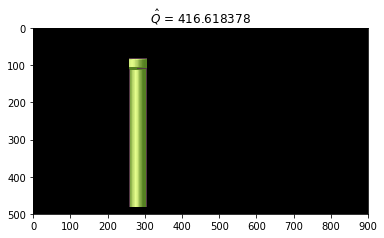

In [ ]:
try:
    netA_t = torch.load("./models/newA.mdl")
    netQ_t = torch.load("./models/newQ.mdl")
except:
    print("Loading 粗问题了")
###


fig = plt.figure()
axe = fig.gca()
pl = axe.imshow(np.random.random([sy, sx]))
for i in range(500):
    IPython.display.clear_output(True)
    s = game.getState()
    a = netA_t(Variable(torch.Tensor(s)))
    hatQ = netQ_t( catsa(s,a) ).data[0]
    pygame.display.set_caption("$\hat{Q}$ = %f" % (hatQ))
    s, l, frame = game.forward(a.data[0], disp=1)
    if l==0:
        game.gameinit()
    ##
    pl.set_data(np.transpose(frame, (1,0,2)))
    axe.set_title("$\hat{Q}$ = %f"%(hatQ))
    IPython.display.display(fig)

###

In [ ]:



for i in range(100):
    s = game.getState()
    a = netA_t(Variable(torch.Tensor(s)))
    hatQ = netQ_t( catsa(s,a) ).data[0]
    pygame.display.set_caption("$\hat{Q}$ = %f " % (hatQ))
    s,l,frame = game.forward( a.data[0], disp=1 )
    
    if l==0:
        game.gameinit()
    ##
    